<a href="https://colab.research.google.com/github/WuzI38/AiSD/blob/main/MusicGenerator/MidiGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt on music generation

## Get the data

In [1]:
!pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wuzi91","key":"ed735dab09a4f84e30d1d94d4c843b42"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download programgeek01/anime-music-midi

100% 707k/707k [00:00<00:00, 2.35MB/s]
100% 707k/707k [00:00<00:00, 2.35MB/s]


In [8]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

### Fix music21 show issues

In [9]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

installing lilypond...
Extracting templates from packages: 100%


In [10]:
# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

installing fluidsynth...


In [11]:
# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

## Loading and preprocessing - library excersises 

### Parsing files from given path

In [12]:
import os
from music21 import *

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

In [13]:
midi_list[1] # Midi 1 is battle against true hero

<music21.stream.Score 0x7f18f828c4c0>

### Extracting notes from music21 stream

In [14]:
# (This cell is mostly stolen from kaggle, but does it really matter?)
# I turned it into a dict cuz I have no idea how to use the library

def part_to_dict(midi_part):
  # If what I think is correct midi stream is divided into midi parts which 
  # Represents instruments (or left/right hand piano melody)
  notes_as_dict = []
  for n in midi_part.flat.notes:     
    sound_dict = dict()
    if isinstance(n, note.Note):
      sound_dict["type"] = "Note"
      sound_dict["pitch"] = max(0.0, n.pitch.ps)
      sound_dict["duration"] = n.duration.quarterLength
    elif isinstance(n, chord.Chord):
      sound_dict["type"] = "Chord"
      sound_dict["pitches"] = [] 
      for pitch in n.pitches:
        sound_dict["pitches"].append(max(0.0, pitch.ps))
    sound_dict["duration"] = n.duration.quarterLength
    sound_dict["offset"] = n.offset
    notes_as_dict.append(sound_dict)
    
  return notes_as_dict

part_to_dict(midi_list[1])[0:5]

[{'type': 'Note', 'pitch': 65.0, 'duration': 1.0, 'offset': 0.0},
 {'type': 'Note', 'pitch': 43.0, 'duration': 0.25, 'offset': 0.0},
 {'type': 'Note', 'pitch': 36.0, 'duration': 1.0, 'offset': 0.0},
 {'type': 'Note', 'pitch': 43.0, 'duration': 0.25, 'offset': 0.5},
 {'type': 'Note', 'pitch': 65.0, 'duration': 1.0, 'offset': 1.0}]

In [15]:
# Original function (no dict)
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
      if isinstance(nt, note.Note):
        ret.append(max(0.0, nt.pitch.ps))
        parent_element.append(nt)
      elif isinstance(nt, chord.Chord):
        for pitch in nt.pitches:
          ret.append(max(0.0, pitch.ps))
          parent_element.append(nt)
    
    return ret, parent_element
extract_notes(midi_list[1])[1][0:5]

[<music21.note.Note F>,
 <music21.note.Note G>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note F>]

### Divide midi into midi parts

In [41]:
def fragmentise(midi_stream):
  return [part.flat.notes for part in midi_stream.parts]

parts = fragmentise(midi_list[0])
part_to_dict(parts[0])[0:5]

[{'type': 'Chord',
  'pitches': [70.0, 74.0, 79.0],
  'duration': 1.25,
  'offset': 0.0},
 {'type': 'Note', 'pitch': 43.0, 'duration': 0.5, 'offset': 0.0},
 {'type': 'Note', 'pitch': 55.0, 'duration': 0.25, 'offset': 0.5},
 {'type': 'Note', 'pitch': 43.0, 'duration': 0.5, 'offset': 0.75},
 {'type': 'Chord', 'pitches': [67.0, 55.0], 'duration': 0.25, 'offset': 1.25}]

## Turn those midi files into somethig readable... I mean visualization

### Creating play and show functions

In [42]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

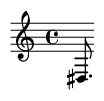

In [18]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(0.75)
show(n)

In [19]:
play(n)

### Visualizing the first 12 sounds using extracted notes only 
I know, I don't have to create midi stream once again, but I just wanna check if it works as intended

In [20]:
def create_midi_part(part_n):
  sounds_12 = []
  # Create really ugly and unnecessary for loop just for 
  for sound in part_n:
    if sound["type"] == "Note":
      new_note = note.Note(sound["pitch"], quarterLength=sound["duration"]) # use .nameWithOctave for note name only
    else:
      new_note = chord.Chord([int (s) for s in sound["pitches"]], quarterLength=sound["duration"])
    new_note.offset = sound["offset"]
    sounds_12.append(new_note)
  return sounds_12 

  # This is so bad... but the melody is correct, so I shouldn't complain

In [47]:
part_1 = part_to_dict(parts[0])[:48]
# part_2 = part_to_dict(parts[1])[:10]
midi_part_1 = create_midi_part(part_1)
# midi_part_2 = create_midi_part(part_2)

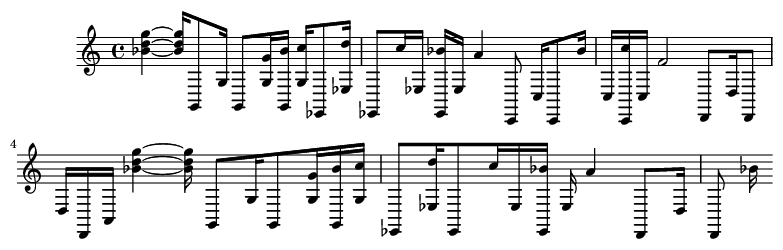

In [44]:
# Visualize stream
melody_midi = stream.Stream(midi_part_1)
# melody_midi_2 = stream.Stream(midi_part_2)
# melody_joined = stream.Stream([melody_midi, melody_midi_2])
melody_joined = melody_midi
show(melody_joined) # Yep, looks legit

In [45]:
# melody_midi.show('text') There are even two instruments playing together... nice
play(melody_joined)

## Stats

### Counting notes
Soooo... I assume there are some notes that appear more frequently than the others. I guess I should do something similar to what text models try to accomplish and remove useless sounds (use just top 95%)?

As the initial research on how to use the library was made, this time I will create a function(based on part_to_dict function) that represents notes as values dependent of time (timesteps) - (offset, pitch, length).

In [48]:
def get_all_notes(midi_piece, notes_only=False, tabu_list=None):
  all_notes = []
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      if tabu_list is not None and nt.pitch.ps in tabu_list:
        continue 
      all_notes.append((nt.offset, max(0.0, nt.pitch.ps), nt.duration.quarterLength) if not notes_only else nt.pitch.ps)
    elif isinstance(nt, chord.Chord):
      for n in nt.pitches:
        if tabu_list is not None and n.ps in tabu_list:
          continue 
        all_notes.append((nt.offset, max(0.0, n.ps), nt.duration.quarterLength) if not notes_only else n.ps)
  return all_notes

notes_list = get_all_notes(midi_list[0])
notes_list[:10]

[(0.0, 70.0, 1.25),
 (0.0, 74.0, 1.25),
 (0.0, 79.0, 1.25),
 (0.0, 43.0, 0.5),
 (0.5, 55.0, 0.25),
 (0.75, 43.0, 0.5),
 (1.25, 67.0, 0.25),
 (1.25, 55.0, 0.25),
 (1.5, 70.0, 0.25),
 (1.5, 43.0, 0.25)]

Count notes first

In [49]:
import itertools

# Make a wrapper to use map later
def gan_true_wrapper(midi_piece):
  return get_all_notes(midi_piece, True)

all_midis_combined = (list(itertools.chain.from_iterable(map(gan_true_wrapper, midi_list))))

In [26]:
from collections import Counter

def find_frequencies(counter):
    # Use Counter to count the frequency of elements in the list
    values = list(counter.values())

    # Find the least frequent value
    least_frequent = min(values)

    # Find the most frequent value
    most_frequent = max(values)

    # Find the average frequency
    avg_frequency = sum(values) / len(values)

    return values, least_frequent, most_frequent, avg_frequency

notes_counted = Counter(all_midis_combined)
values, least_frequent, most_frequent, avg_frequency = find_frequencies(notes_counted)
print("Least frequent value:", least_frequent)
print("Most frequent value:", most_frequent)
print("Average frequency:", avg_frequency)

Least frequent value: 2
Most frequent value: 3375
Average frequency: 1052.746835443038


Plot a graph representing notes' distributions

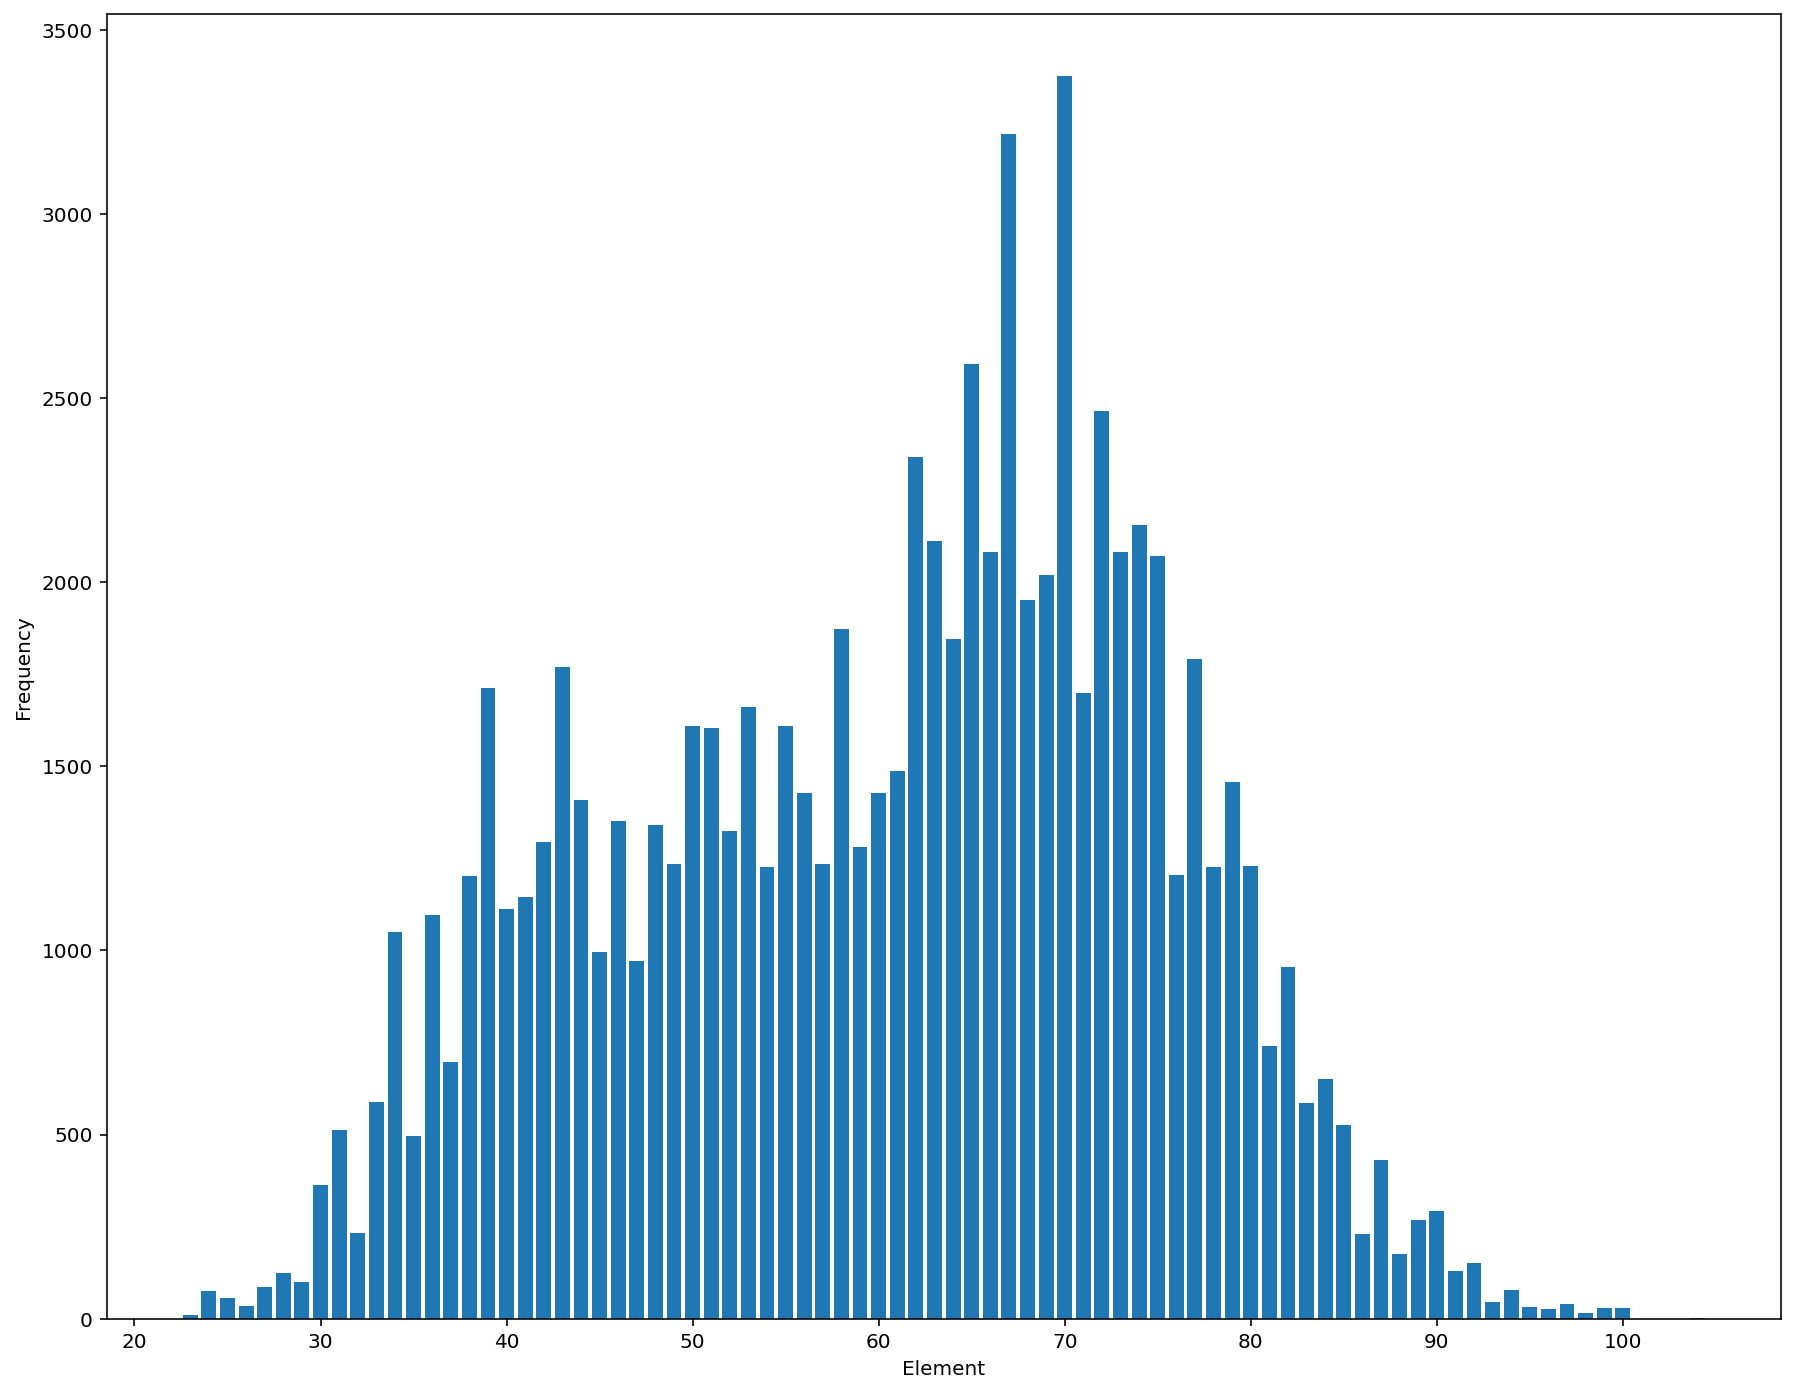

In [27]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_frequencies(counter):

    # Extract the elements and their frequencies
    elements, frequencies = zip(*counter.items())

    # Plot the frequencies as a bar chart
    plt.bar(elements, frequencies)
    plt.xlabel("Element")
    plt.ylabel("Frequency")
    plt.show()

plt.figure(figsize=(15, 12))
plot_frequencies(notes_counted)

### Create list of all notes in every single piece (+ durations and timestamps) excluding least frequent notes (I can assume those are not important)

In [28]:
tabu = [element for element, frequency in notes_counted.items() if frequency < 0.05 * most_frequent]
tabu

[28.0,
 23.0,
 24.0,
 26.0,
 25.0,
 27.0,
 29.0,
 95.0,
 97.0,
 93.0,
 94.0,
 91.0,
 99.0,
 92.0,
 96.0,
 98.0,
 100.0,
 104.0]

In [29]:
def tabu_wrapper(midi_piece):
  return get_all_notes(midi_piece, False, tabu)

notes_full = list(map(get_all_notes, midi_list))

In [50]:
notes_full[0][:10]

[(0.0, 70.0, 1.25),
 (0.0, 74.0, 1.25),
 (0.0, 79.0, 1.25),
 (0.0, 43.0, 0.5),
 (0.5, 55.0, 0.25),
 (0.75, 43.0, 0.5),
 (1.25, 67.0, 0.25),
 (1.25, 55.0, 0.25),
 (1.5, 70.0, 0.25),
 (1.5, 43.0, 0.25)]

### Try to visualize songs on charts

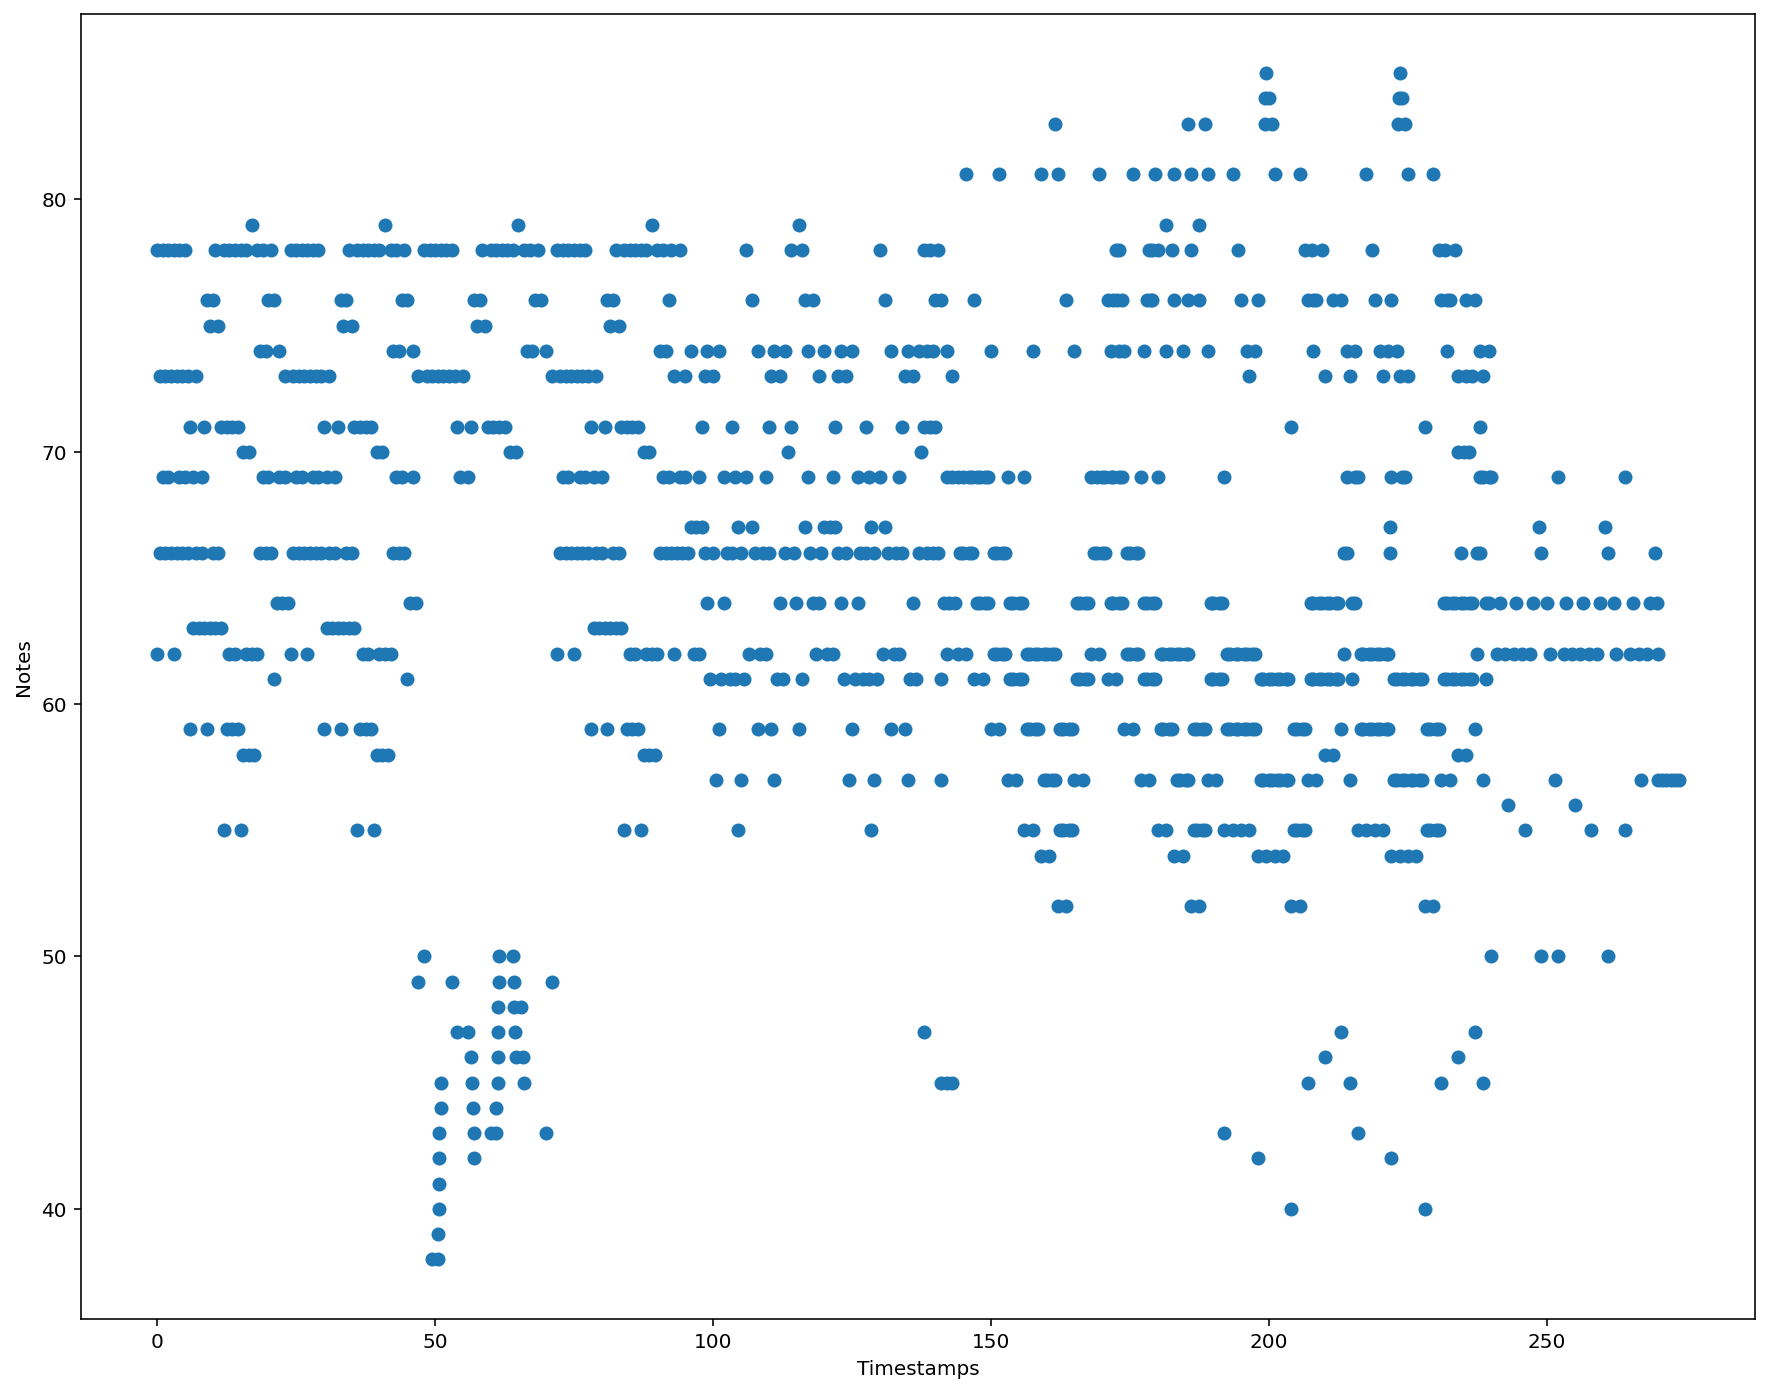

In [31]:
import numpy as np
notes_np_zero = np.array(notes_full[2])
plt.figure(figsize=(15, 12))
plt.xlabel("Timestamps")
plt.ylabel("Notes")
plt.scatter(notes_np_zero[:, 0], notes_np_zero[:, 1])

## Formatting data part 2 - creating train test split and introducing dataset windowing

### Dataset windowing

We have to remove pieces that are to short - for example after performing train test split pieces of length 20 would have only 4 notes in test section, which might not be enough to create windows

In [59]:
TRAIN_TEST_SPLIT_VAL = 0.8
WINDOW_SIZE = 10
HORIZON_SIZE = 1

In [62]:
import pandas as pd

def window(lst, window_size=WINDOW_SIZE, horizon_size=HORIZON_SIZE):
  if len(lst) < window_size:
    return False

  df = pd.DataFrame(lst, columns=["Offset", "Pitch", "Length"])
  return df
  
dfh = window(notes_full[0]).head()

dfh[f"Extra"] = dfh["Pitch"].shift(periods=1)
dfh

,Offset,Pitch,Length,Extra
0,0.0,70.0,1.25,NaN
1,0.0,74.0,1.25,70.0
2,0.0,79.0,1.25,74.0
3,0.0,43.0,0.50,79.0
4,0.5,55.0,0.25,43.0


In [56]:
vocab = [element for element, frequency in notes_counted.items() if element not in tabu]

In [63]:
import pandas as pd

df = pd.DataFrame({
    'col1': ['A', 'B', 'C'],
    'col2': ['D', 'E', 'F'],
    'col3': ['G', 'H', 'I']
})

def join_cells(row):
    return row['col1'] + row['col2'] + row['col3']

df['joined_column'] = df.apply(join_cells, axis=1)

print(df)

  col1 col2 col3 joined_column
0    A    D    G           ADG
1    B    E    H           BEH
2    C    F    I           CFI
